# APIM ❤️ OpenAI

## Backend pool Load Balancing lab
![flow](images/backend-pool-load-balancing.gif)

Playground to try the built-in load balancing [backend pool functionality of APIM](https://learn.microsoft.com/en-us/azure/api-management/backends?tabs=bicep) to either a list of Azure OpenAI endpoints or mock servers.

Notes:
- The backend pool uses round-robin by default
- But priority and weight based routing are also supported: Adjust the `priority` (the lower the number, the higher the priority) and `weight` parameters in the `openai_resources` variable
- The `retry` API Management policy initiates a retry to an available backend if an HTTP 429 status code is encountered

### Result
![result](images/result.png)

<a id='2'></a>
### 2️⃣ Create deployment using Terraform

This lab uses Terraform to declaratively define all the resources that will be deployed. Change the [variables.tf](variables.tf) directly to try different configurations.

In [ ]:
! terraform init
! terraform apply -auto-approve

<a id='3'></a>
### 3️⃣ Get the deployment outputs

We are now at the stage where we only need to retrieve the gateway URL and the subscription before we are ready for testing.

In [1]:
apim_resource_gateway_url = ! terraform output -raw apim_resource_gateway_url
apim_resource_gateway_url = apim_resource_gateway_url.n
print("👉🏻 APIM Resource Gateway URL: ", apim_resource_gateway_url)

apim_subscription_key = ! terraform output -raw apim_subscription_key
apim_subscription_key = apim_subscription_key.n
print("👉🏻 APIM Subscription Key: ", apim_subscription_key)

openai_api_version = "2024-10-21"
openai_model_name = "gpt-4o"
openai_deployment_name = "gpt-4o"

👉🏻 APIM Resource Gateway URL:  https://apim-genai-310.azure-api.net
👉🏻 APIM Subscription Key:  6d64e9754cfa47b5bdf635cafd751900


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses. 

You will not see HTTP 429s returned as API Management's `retry` policy will select an available backend. If no backends are viable, an HTTP 503 will be returned.

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior of the backend pool.

>If you get `Acess denied` response, then you need to validate the `APIM` subscription key on the Azure portal.

In [2]:
import time
import os
import json
import datetime
import requests

runs = 20
sleep_time_ms = 200
url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []

for i in range(runs):
    print("▶️ Run:", i+1, "/", runs)
    

    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}

    start_time = time.time()
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    response_time = time.time() - start_time
    
    print(f"⌚ {response_time:.2f} seconds")
    # Check the response status code and apply formatting
    if 200 <= response.status_code < 300:
        status_code_str = '\x1b[1;32m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and green
    elif response.status_code >= 400:
        status_code_str = '\x1b[1;31m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and red
    else:
        status_code_str = str(response.status_code)  # No formatting

    # Print the response status with the appropriate formatting
    print("Response status:", status_code_str)
    
    print("Response headers:", response.headers)
    
    if "x-ms-region" in response.headers:
        print("x-ms-region:", '\x1b[1;31m'+response.headers.get("x-ms-region")+'\x1b[0m') # this header is useful to determine the region of the backend that served the request
        api_runs.append((response_time, response.headers.get("x-ms-region")))
    
    if (response.status_code == 200):
        data = json.loads(response.text)
        print("Token usage:", data.get("usage"), "\n")
        print("💬 ", data.get("choices")[0].get("message").get("content"), "\n")
    else:
        print(response.text)   

    time.sleep(sleep_time_ms/1000)

▶️ Run: 1 / 20
⌚ 12.53 seconds
Response status: 401 - Access Denied
Response headers: {'Content-Length': '143', 'Content-Type': 'application/json', 'Date': 'Wed, 01 Jan 2025 12:00:54 GMT', 'Cache-Control': 'private', 'WWW-Authenticate': 'AzureApiManagementKey realm="https://apim-genai-310.azure-api.net/openai",name="api-key",type="header"'}
{ "statusCode": 401, "message": "Access denied due to invalid subscription key. Make sure to provide a valid key for an active subscription." }
▶️ Run: 2 / 20
⌚ 0.25 seconds
Response status: 401 - Access Denied
Response headers: {'Content-Length': '143', 'Content-Type': 'application/json', 'Date': 'Wed, 01 Jan 2025 12:00:54 GMT', 'Cache-Control': 'private', 'WWW-Authenticate': 'AzureApiManagementKey realm="https://apim-genai-310.azure-api.net/openai",name="api-key",type="header"'}
{ "statusCode": 401, "message": "Access denied due to invalid subscription key. Make sure to provide a valid key for an active subscription." }
▶️ Run: 3 / 20
⌚ 0.21 secon

<a id='plot'></a>
### 🔍 Analyze Load Balancing results

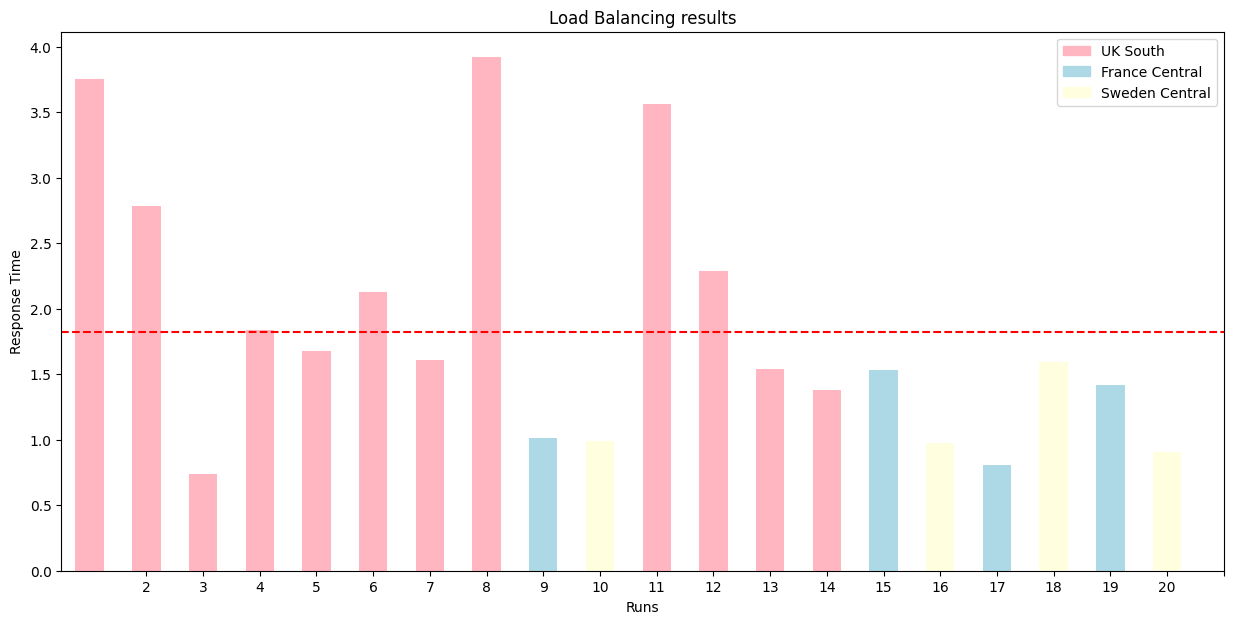

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'UK South': 'lightpink', 'France Central': 'lightblue', 'Sweden Central': 'lightyellow', 'Region3': 'red', 'Region4': 'orange'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind='bar', x='Run', y='Response Time', color=[color_map.get(region, 'gray') for region in df['Region']], legend=False)

# Add legend
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Runs')
plt.ylabel('Response Time')
plt.xticks(df['Run'], rotation=0)

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')

plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility.

In [8]:
import time
from openai import AzureOpenAI

runs = 9
sleep_time_ms = 0

for i in range(runs):
    print("▶️ Run: ", i+1)

    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]

    client = AzureOpenAI(
        azure_endpoint=apim_resource_gateway_url,
        api_key=apim_subscription_key,
        api_version=openai_api_version
    )

    start_time = time.time()

    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    
    response_time = time.time() - start_time
    print(f"⌚ {response_time:.2f} seconds")
    print("💬 ", response.choices[0].message.content)
    time.sleep(sleep_time_ms/1000)


▶️ Run:  1
⌚ 1.87 seconds
💬  Oh, absolutely! Just let me whip out my magical time-telling abilities that work over text. Or, you know, you could just look at literally any device around you that you own. 😏
▶️ Run:  2
⌚ 7.35 seconds
💬  Oh sure, let me just grab my imaginary watch and check the time for you. If only I had that ability! You might have more luck with a clock or your phone.
▶️ Run:  3
⌚ 2.33 seconds
💬  Oh, absolutely! Because I'm sure your numerous devices that tell time are nowhere to be found, right? Unfortunately, I can't check the time for you, but I'm confident you'll figure it out!
▶️ Run:  4
⌚ 1.67 seconds
💬  Of course! Just gaze at the nearest clock or check one of the myriad of devices you likely have around you. They're surprisingly good at keeping time!
▶️ Run:  5
⌚ 3.19 seconds
💬  Oh sure, let me just tap into my nonexistent ability to see the current time. Unfortunately, you'll have to check a clock or a device for that one. I know, it's an arduous task!
▶️ Run